In [1]:
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


# Generate Simulation Data

In [42]:
class SingleShotTracesGenerator:
    def __init__(self, model='inf_lifetime', snr=100, time=100, seed=0):
        self.model = model
        self.snr = snr
        self.seed = seed
        self.time = time
        np.random.seed(seed)
    
    def generate(self, n, state, time=None, snr=None):
        if time is None:
            time = self.time
        if snr is None:
            snr = self.snr
        model = SingleShotTracesGenerator.models[self.model]
        return np.asarray([model(state, time, snr) for _ in range(n)])
    
    @staticmethod
    def _wiener(mean, time, snr, init=0+0.j):
    #def _wiener(mean, time, snr, init=np.array([0,0])):
        process = [init]
        for t in range(time - 1):
            new = init + complex(np.random.normal(0., np.sqrt(1/snr)), np.random.normal(0., np.sqrt(1/snr)))
            #new = init + np.array([np.random.normal(0., np.sqrt(1/snr)), np.random.normal(0., np.sqrt(1/snr))])
            process.append(new)
        return np.asarray(process)
    
    @staticmethod
    def _inf_lifetime(state, time, snr):
        if state == 0:
            mean = 1. + 0.j
            #mean = [1., 0.]
        elif state == 1:
            mean = 0 + 2.j
            #mean = [0., 1.]
        elif state == 2:
            mean = -1. + 0.j
            #mean = [-1., 0.]
        return SingleShotTracesGenerator._wiener(mean, time, snr, init=mean)
    
    models = dict(inf_lifetime=_inf_lifetime.__func__)
        

In [52]:
n_traces = 500
time = 100
plot_mean = False

sstg = SingleShotTracesGenerator(time=time)

g = sstg.generate(n_traces, state=0)
e = sstg.generate(n_traces, state=1)
f = sstg.generate(n_traces, state=2)

# if plot_mean:
#     plt.plot(np.mean(g.real, axis=0), np.mean(g.imag, axis=0), color='b')
#     plt.plot(np.mean(e.real, axis=0), np.mean(e.imag, axis=0), color='r')
#     plt.plot(np.mean(f.real, axis=0), np.mean(f.imag, axis=0), color='g')
# else:
#     for i in range(n_traces):
#         plt.plot(g[i].real, g[i].imag, color='b', alpha=0.01)
#         plt.plot(e[i].real, e[i].imag, color='r', alpha=0.01)
#         plt.plot(f[i].real, f[i].imag, color='g', alpha=0.01)
        
        

# Find Basis and Orthonormalize

In [18]:
def normalize(v):
        return v / np.sqrt(v.dot(v.conjugate()))

def gs(A):
    A[:, 0] = normalize(A[:, 0])

    for i in range(1, A.shape[1]):
        Ai = A[:, i]
        for j in range(0, i):
            Aj = A[:, j]
            t = Ai.dot(Aj.conjugate())
            Ai = Ai - t * Aj
        A[:, i] = normalize(Ai)
    return A

In [20]:
np.vstack([np.mean(e, axis=0) - np.mean(g, axis=0), 
             np.mean(f, axis=0) - np.mean(g, axis=0)]).shape

(2, 8000)

In [53]:
w = gs(np.vstack([np.mean(e, axis=0) - np.mean(g, axis=0), 
             np.mean(f, axis=0) - np.mean(g, axis=0)]).transpose())

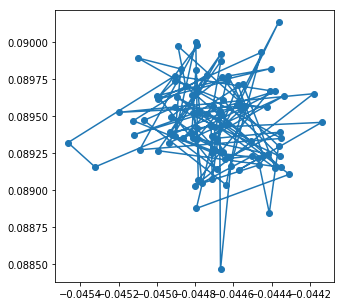

In [56]:
fig, ax = plt.subplots(1, figsize=[5,5])
ax.plot(w[:,0].imag , marker='o')


In [48]:
np.angle(1 + 2j, deg=True)

63.43494882292201

In [46]:
np.angle(w[0,0], deg=True)

116.56505117707799

In [49]:
w

array([[-0.20021576+0.40043152j, -0.01302901+0.25327451j],
       [-0.19864795+0.39971228j, -0.22134655-0.1059649j ],
       [-0.19826503+0.39924841j, -0.41047582-0.40874663j],
       [-0.19885546+0.40063733j,  0.37030525-0.25609276j],
       [-0.20073644+0.40159698j,  0.2696436 +0.5142743j ]])

In [299]:
np.vstack([np.mean(e, axis=0) - np.mean(g, axis=0), 
             np.mean(f, axis=0) - np.mean(g, axis=0)]).transpose()

array([[-1.        , -1.0278917 , -0.97919665, -2.        , -1.98915811,
        -1.96758979],
       [ 1.        ,  0.99299786,  0.97810687,  0.        ,  0.00933629,
        -0.00838355]])

# Wavenet

In [4]:
from WaveNetClassifier import WaveNetClassifier


In [5]:
wnc = WaveNetClassifier((8000, 2), (3,), 
                        kernel_size=2, 
                        dilation_depth=9, 
                        n_filters=10, 
                        task='classification')



Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     (None, 8000, 2)      0                                            
__________________________________________________________________________________________________
dilated_conv_1 (Conv1D)         (None, 8000, 10)     50          original_input[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_tanh (Conv1D)    (None, 8000, 10)     210         dilated_conv_1[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_sigm (Conv1D)    (None, 8000, 10)     210         dilated_conv_1[0][0]             
_____________________________________

In [14]:
dataset = np.array([])
truths = [np.zeros(g.shape[0], dtype=np.int), np.ones(e.shape[0], dtype=np.int), np.ones(f.shape[0], dtype=np.int)*2]
for state, truth in zip([g,e,f], truths):
    temp = np.moveaxis(np.array([state.real,state.imag]), 0,-1)
    if dataset.shape ==(0,):
        dataset = temp
    else:
        dataset = np.vstack([dataset, temp])
dataset_truths = np.hstack(truths)
print(dataset.shape)
print(dataset_truths.shape)


(1500, 8000, 2)
(1500,)


In [16]:
X_train, X_val, y_train, y_val = train_test_split(dataset, to_categorical(dataset_truths))
#X_train, X_val, y_train , y_val = train_test_split(np.random.rand(15, 96000),to_categorical(np.random.randint(10, size=15)))
print(X_train.shape, y_train.shape)

(1125, 8000, 2) (1125, 3)


In [17]:
wnc.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=1, batch_size=32, optimizer='adam', save=True, save_dir='./')
#y_pred = wnc.predict(X_test)

Instructions for updating:
Use tf.cast instead.
Train on 1125 samples, validate on 375 samples
Epoch 1/1
1125/1125 [==============================] - 147s 130ms/step - loss: 0.2410 - acc: 0.9307 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to ./saved_wavenet_clasifier.h5


In [10]:
from keras.utils import plot_model
plot_model(wnc.get_model(), to_file='model.png', show_shapes=True, show_layer_names=True)

In [9]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'